In [1]:
%load_ext autoreload
%autoreload 2

some imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# some imports from my project library
from turboflow.dataloaders import load_turbo2D_simple_numpy
from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp
from turboflow.utils import torch_utils as tch
from turboflow.utils import viz_utils as viz
from turboflow import evaluation as evl


# import torch lib
import torch
from turboflow.dataloaders import Turbo2D_simple
from torch.utils.data import Dataset, DataLoader

In [22]:
device = tch.get_device()

Torch running on: cuda:0


In [27]:
results_dict = {}

Prepare data loader

In [23]:
# ds=downsampling factor
Xlr, Ulr = load_turbo2D_simple_numpy(ds=4) # low resolution (64x64)
Xmr, Umr = load_turbo2D_simple_numpy(ds=2) # mid resolution (128x128)
Xhr, Uhr = load_turbo2D_simple_numpy(ds=1) # high (max) resolution (256x256)

L = int(Xlr.shape[0]**0.5)
M = int(Xmr.shape[0]**0.5)
H = int(Xhr.shape[0]**0.5)


dm_dict = {}

dm_dict['None'] = DataModule(
    train_data=[Xtrain, ytrain],
    val_data=[Xtrain, ytrain],
    test_data =[Xtest, ytest]
)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Y shape (128, 128, 2)
Y min, max: -2.371183 2.985797
after normalization, Y min, max: -0.7941541236728418 1.0
Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0
Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0


## With vs Without RFF

### With RFF

In [47]:
from turboflow.models.phyrff_hard import DivFreeRFFNet

# model (RFF + MLP)
do_rff = True
fft_scale = 10
fft_nfeat = 256

nin = 2  # = x and y coordinates
nout = 1 # = in the mlp we predict the potential, ux and uy components followed
mlp_layers = [nin] + [256]*3 + [nout]
last_activation_fun = torch.nn.Tanh()

hardcoded_divfree = False

model = DivFreeRFFNet('DivFreeNet_RFF', 
                      mlp_layers, last_activation_fun,
                      do_rff, fft_nfeat, fft_scale)

# TRAIN!
model.to(device)
model.fit(trainloader, epochs=3000) # we are not afraid to overfit the data, this is coord-based MLP!
results_dict[model.name] = evl.results_potential_to_dict(Xlr, Xmr, Xhr, Ulr, Umr, Uhr, model, device)

Epoch:    1, Loss: (rec: [15.353746] + 1.00 * div-free: [0.000024]) = 15.353771
Epoch:  100, Loss: (rec: [0.067323] + 1.00 * div-free: [0.000001]) = 0.067324
Epoch:  200, Loss: (rec: [0.047378] + 1.00 * div-free: [0.000001]) = 0.047379
Epoch:  300, Loss: (rec: [0.036181] + 1.00 * div-free: [0.000001]) = 0.036182
Epoch:  400, Loss: (rec: [0.028631] + 1.00 * div-free: [0.000001]) = 0.028632
Epoch:  500, Loss: (rec: [0.022937] + 1.00 * div-free: [0.000001]) = 0.022938
Epoch:  600, Loss: (rec: [0.018302] + 1.00 * div-free: [0.000001]) = 0.018303
Epoch:  700, Loss: (rec: [0.014376] + 1.00 * div-free: [0.000001]) = 0.014377
Epoch:  800, Loss: (rec: [0.011033] + 1.00 * div-free: [0.000001]) = 0.011034
Epoch:  900, Loss: (rec: [0.008251] + 1.00 * div-free: [0.000001]) = 0.008252
Epoch: 1000, Loss: (rec: [0.006034] + 1.00 * div-free: [0.000001]) = 0.006035
Epoch: 1100, Loss: (rec: [0.004354] + 1.00 * div-free: [0.000001]) = 0.004355
Epoch: 1200, Loss: (rec: [0.003139] + 1.00 * div-free: [0.0000

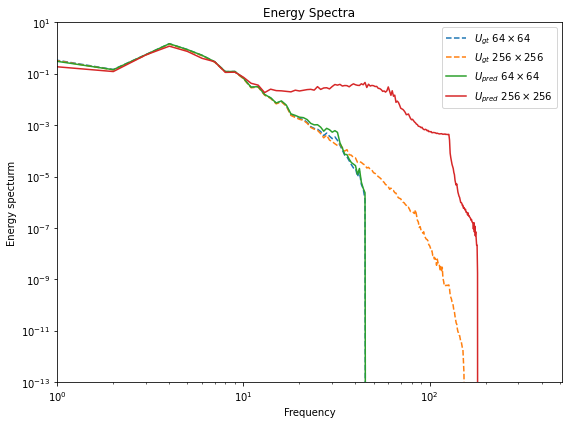

In [42]:
u_dicts = [
    {'vel':Ulr, 'size':L, 'label': r'$U_{gt}$ $64 \times 64$', 'style': '--'},
    {'vel':Uhr, 'size':H, 'label': r'$U_{gt}$ $256 \times 256$', 'style': '--'},
    {'vel':results_dict[model.name]['LR']['u'], 
     'size':results_dict[model.name]['LR']['size'],
     'label': r'$U_{pred}$ $64 \times 64$', 'style': '-'},
    {'vel':results_dict[model.name]['HR']['u'], 
     'size':results_dict[model.name]['HR']['size'], 
     'label': r'$U_{pred}$ $256 \times 256$', 'style': '-'},
]

viz.plot_energy_spectra(u_dicts, title='Energy Spectra')
plt.show()

### Without RFF

In [45]:
from turboflow.models.phyrff_hard import DivFreeRFFNet

# model (RFF + MLP)
do_rff = False
fft_scale = 10
fft_nfeat = 256

nin = 2  # = x and y coordinates
nout = 1 # = ux and uy components
mlp_layers = [nin] + [256]*3 + [nout]
last_activation_fun = torch.nn.Tanh()

hardcoded_divfree = False

model = DivFreeRFFNet('DivFreeNet', 
                      mlp_layers, last_activation_fun,
                      do_rff, fft_nfeat, fft_scale, hardcoded_divfree=False)

# TRAIN!
model.to(device)
model.fit(trainloader, epochs=7000) # we are not afraid to overfit the data, this is coord-based MLP!
results_dict[model.name] = evl.results_potential_to_dict(Xlr, Xmr, Xhr, Ulr, Umr, Uhr, model, device)

Epoch:    1, Loss: (rec: [0.065331] + 1.00 * div-free: [0.000000]) = 0.065331
Epoch:  100, Loss: (rec: [0.064378] + 1.00 * div-free: [0.000000]) = 0.064378
Epoch:  200, Loss: (rec: [0.062449] + 1.00 * div-free: [0.000000]) = 0.062449
Epoch:  300, Loss: (rec: [0.057021] + 1.00 * div-free: [0.000000]) = 0.057021
Epoch:  400, Loss: (rec: [0.056362] + 1.00 * div-free: [0.000000]) = 0.056362
Epoch:  500, Loss: (rec: [0.055725] + 1.00 * div-free: [0.000000]) = 0.055725
Epoch:  600, Loss: (rec: [0.055224] + 1.00 * div-free: [0.000000]) = 0.055224
Epoch:  700, Loss: (rec: [0.054823] + 1.00 * div-free: [0.000000]) = 0.054823
Epoch:  800, Loss: (rec: [0.054383] + 1.00 * div-free: [0.000000]) = 0.054383
Epoch:  900, Loss: (rec: [0.053593] + 1.00 * div-free: [0.000000]) = 0.053593
Epoch: 1000, Loss: (rec: [0.052458] + 1.00 * div-free: [0.000000]) = 0.052458
Epoch: 1100, Loss: (rec: [0.049932] + 1.00 * div-free: [0.000000]) = 0.049932
Epoch: 1200, Loss: (rec: [0.046728] + 1.00 * div-free: [0.000000

### Plot results and compare the two metods graphically

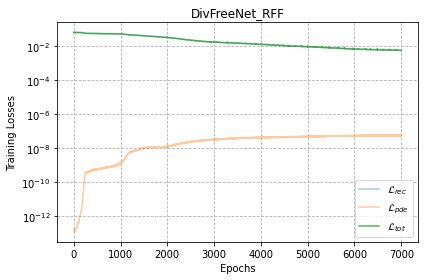

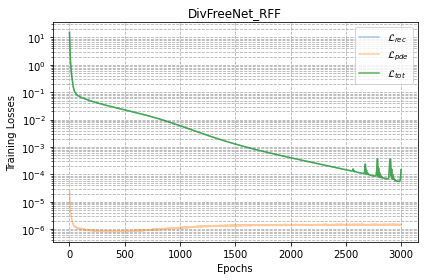

In [49]:
viz.plot_model_losses(results_dict['DivFreeNet'], title=model.name)
plt.show()
viz.plot_model_losses(results_dict['DivFreeNet_RFF'], title=model.name)
plt.show()

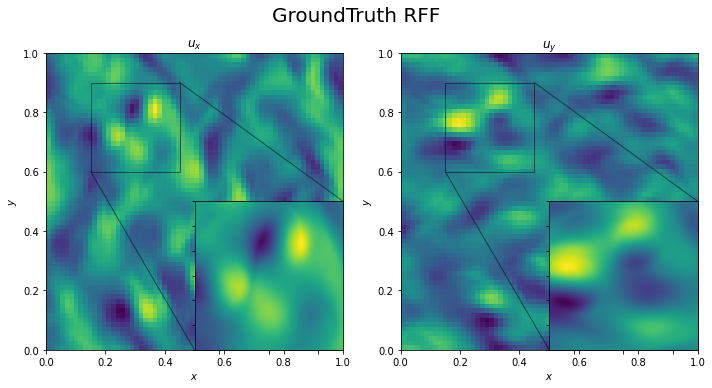

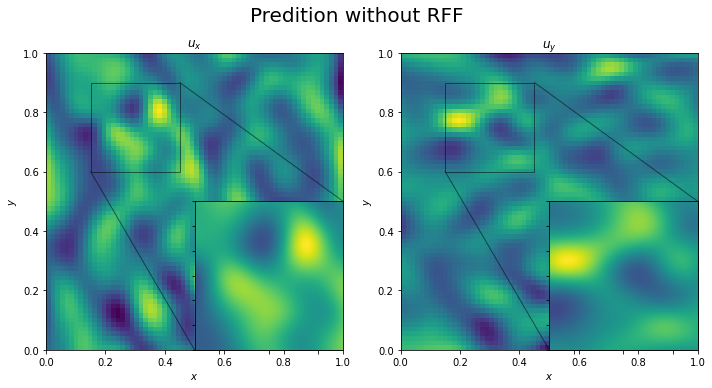

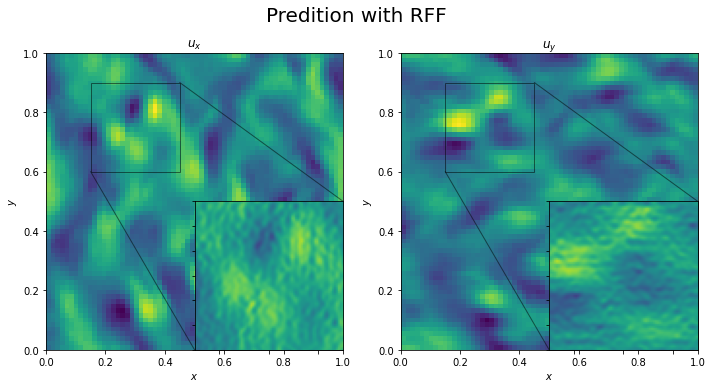

In [54]:
viz.plot_lr_hr_inset(Ulr, Uhr, L, H, title='GroundTruth RFF')
plt.show()
viz.plot_lr_hr_inset_wrapper_res_dict(results_dict['DivFreeNet'], title='Predition without RFF')
plt.show()
viz.plot_lr_hr_inset_wrapper_res_dict(results_dict['DivFreeNet_RFF'], title='Predition with RFF')
plt.show()

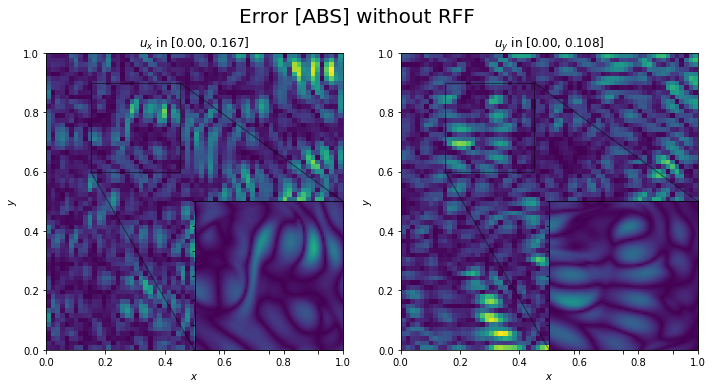

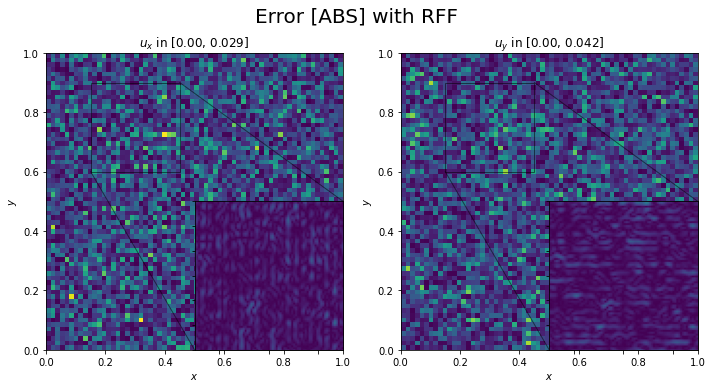

In [56]:
viz.plot_lr_hr_inset_error_wrapper_res_dict(results_dict['DivFreeNet'], title='Error [ABS] without RFF')
plt.show()
viz.plot_lr_hr_inset_error_wrapper_res_dict(results_dict['DivFreeNet_RFF'], title='Error [ABS] with RFF')
plt.show()

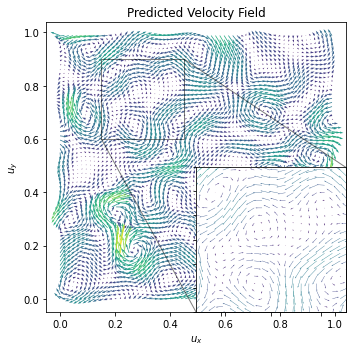

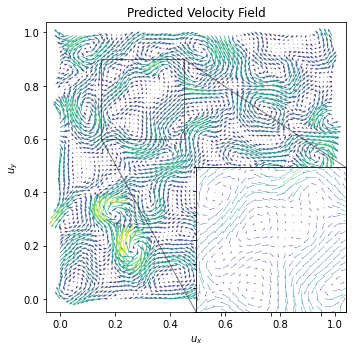

In [58]:
viz.plot_velocity_field_wrapper_res_dict(results_dict['DivFreeNet'], title='Predicted Velocity Field', step_lr=1, scale_lr=15, step_hr=4, scale_hr=5)
plt.show()
viz.plot_velocity_field_wrapper_res_dict(results_dict['DivFreeNet_RFF'], title='Predicted Velocity Field', step_lr=1, scale_lr=15, step_hr=4, scale_hr=5)
plt.show()

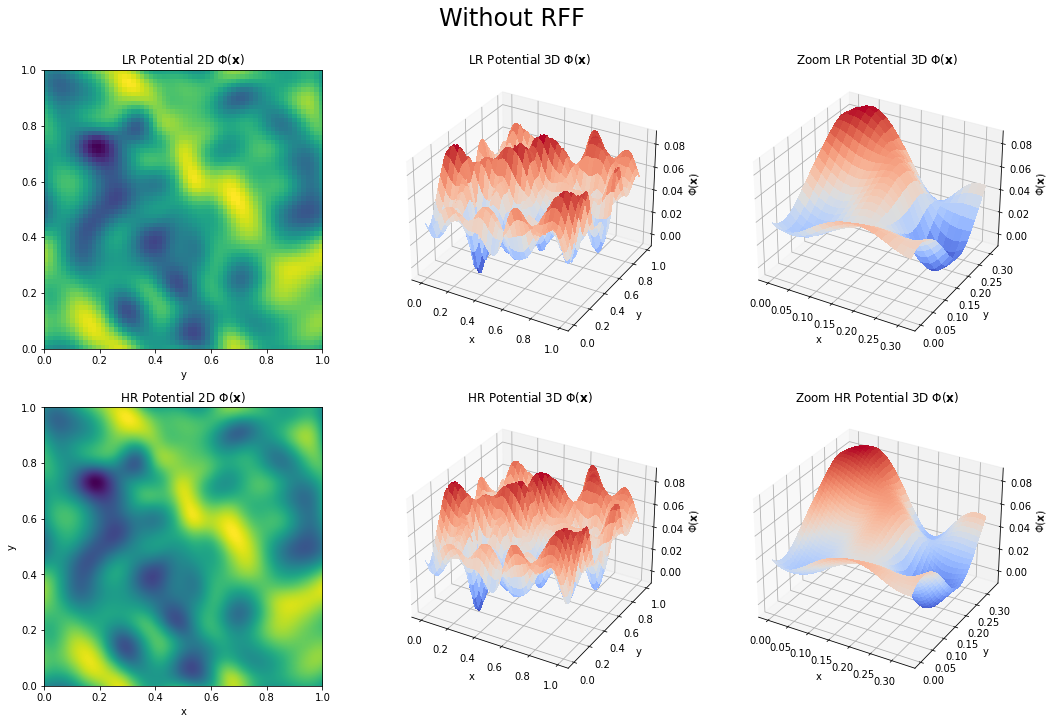

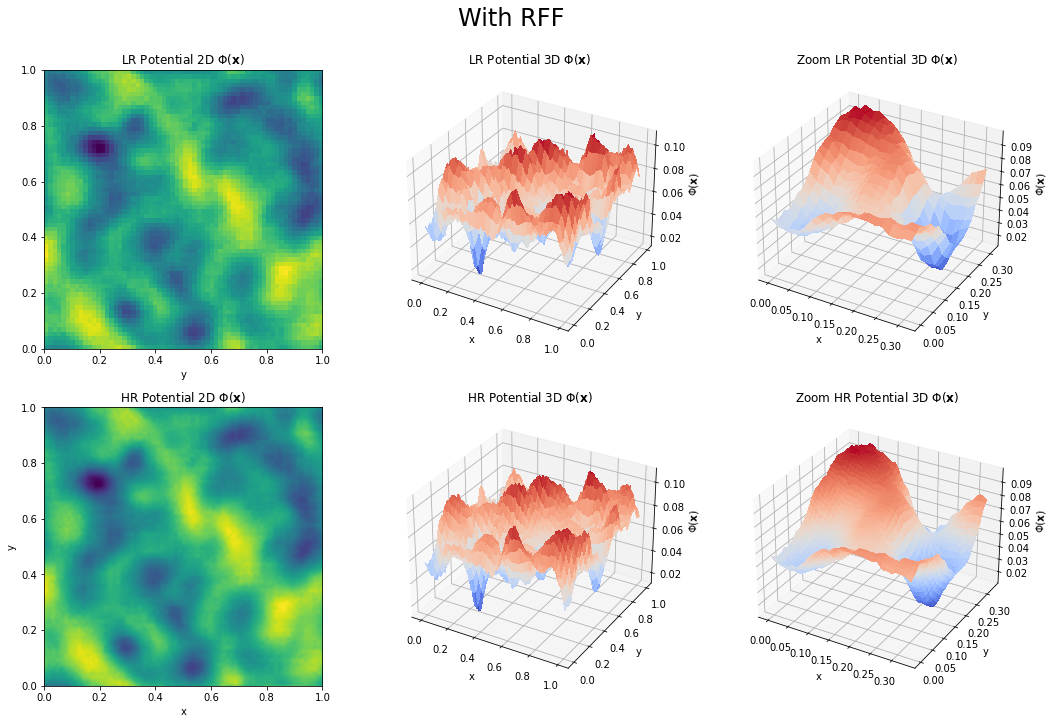

In [64]:
viz.plot_potential_wrapper_res_dict(results_dict['DivFreeNet'], title='Without RFF')
plt.show()
viz.plot_potential_wrapper_res_dict(results_dict['DivFreeNet_RFF'], title='With RFF')
plt.show()

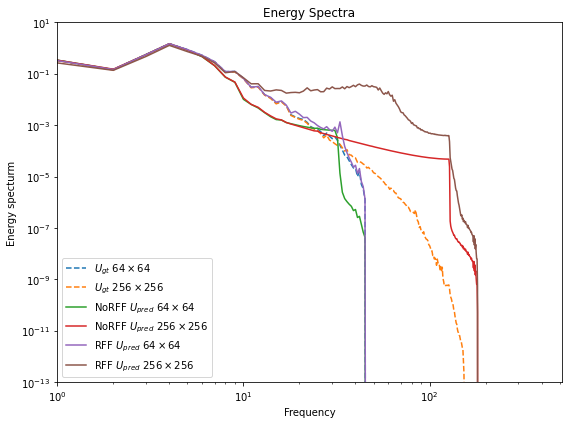

In [66]:
u_dicts = [
    {'vel':Ulr, 'size':L, 'label': r'$U_{gt}$ $64 \times 64$', 'style': '--'},
    {'vel':Uhr, 'size':H, 'label': r'$U_{gt}$ $256 \times 256$', 'style': '--'},
    
    { 'vel':results_dict['DivFreeNet']['LR']['u'], 
     'size':results_dict['DivFreeNet']['LR']['size'],
     'label': r'NoRFF $U_{pred}$ $64 \times 64$', 'style': '-'},
    { 'vel':results_dict['DivFreeNet']['HR']['u'], 
     'size':results_dict['DivFreeNet']['HR']['size'], 
     'label': r'NoRFF $U_{pred}$ $256 \times 256$', 'style': '-'},
    
    { 'vel':results_dict['DivFreeNet_RFF']['LR']['u'], 
     'size':results_dict['DivFreeNet_RFF']['LR']['size'],
     'label': r'RFF $U_{pred}$ $64 \times 64$', 'style': '-'},
    { 'vel':results_dict['DivFreeNet_RFF']['HR']['u'], 
     'size':results_dict['DivFreeNet_RFF']['HR']['size'], 
     'label': r'RFF $U_{pred}$ $256 \times 256$', 'style': '-'},
]

viz.plot_energy_spectra(u_dicts, title='Energy Spectra')
plt.show()

## Nonlinearity at the output

### For-loop on ELU, ReLU, LeakyReLU, Tanh and Sigmoid

In [76]:
# model (RFF + MLP)
do_rff = True
fft_scale = 10
fft_nfeat = 256

nin = 2  # = x and y coordinates
nout = 1 # = in the mlp we predict the potential, ux and uy components followed
mlp_layers = [nin] + [256]*3 + [nout]
last_activation_funs = {'ELU' : torch.nn.ELU(), 
                        'ReLU' : torch.nn.ReLU(),
                        'LeakyReLU' : torch.nn.LeakyReLU(),
                        'Tanh' : torch.nn.Tanh(),
                        'Sigmoid' : torch.nn.Sigmoid()}
hardcoded_divfree = False

for key in last_activation_funs:
    
    print(key)
    
    do_rff = True
    fft_scale = 10
    fft_nfeat = 256

    nin = 2  # = x and y coordinates
    nout = 1 # = in the mlp we predict the potential, ux and uy components followed
    mlp_layers = [nin] + [256]*3 + [nout]

    model = DivFreeRFFNet('DivFreeNet_RFF_%s' % key, 
                          mlp_layers, last_activation_funs[key],
                          do_rff, fft_nfeat, fft_scale, verbose=False)

    # TRAIN!
    model.to(device)
    model.fit(trainloader, epochs=3000) # we are not afraid to overfit the data, this is coord-based MLP!
    results_dict[model.name] = evl.results_potential_to_dict(Xlr, Xmr, Xhr, Ulr, Umr, Uhr, model, device)

ELU
Done with Training
Final error: 6.811886123614386e-05
ReLU
Done with Training
Final error: 0.06479582190513611
LeakyReLU
Done with Training
Final error: 0.004316771402955055
Tanh
Done with Training
Final error: 0.00040872988756746054
Sigmoid
Done with Training
Final error: 9.280459198635072e-05


### Inspect results

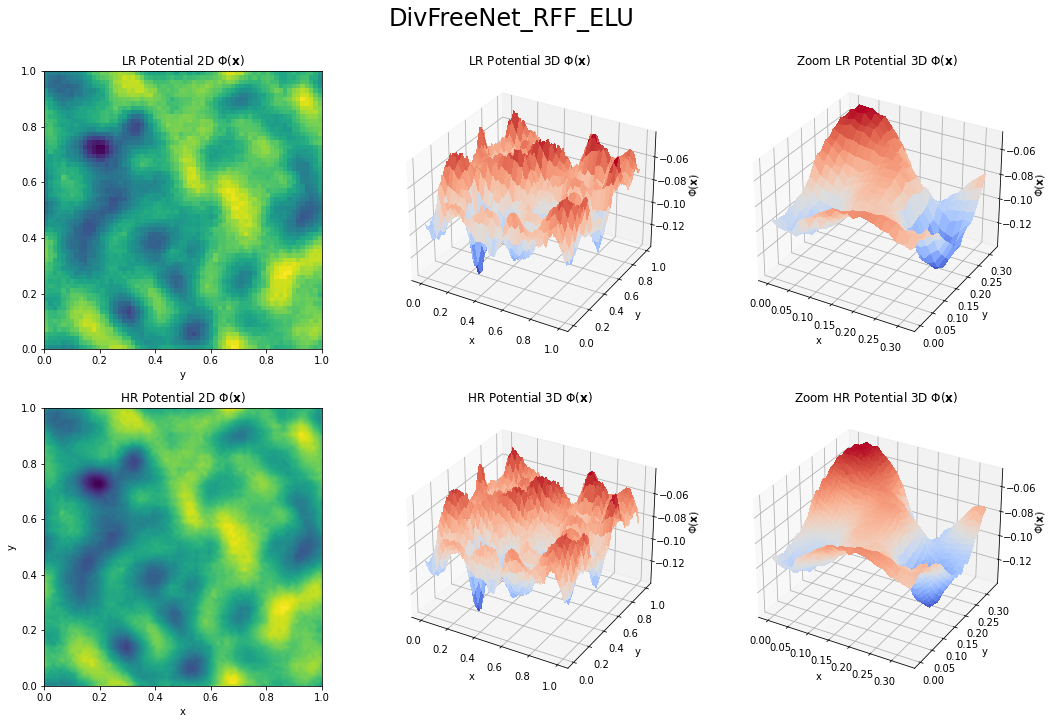

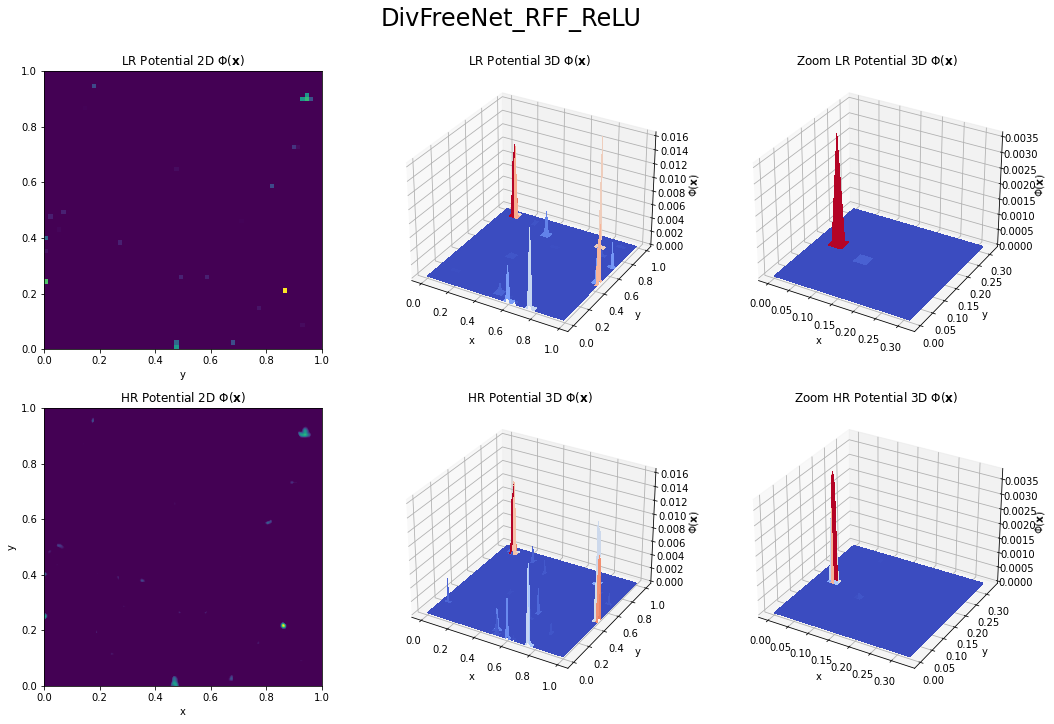

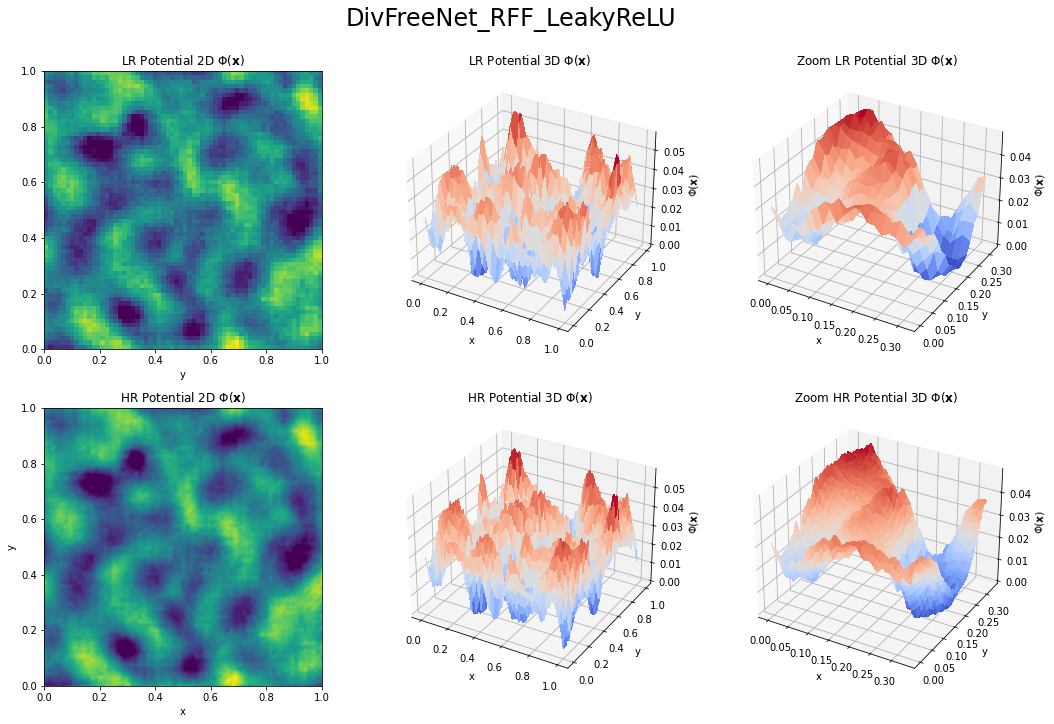

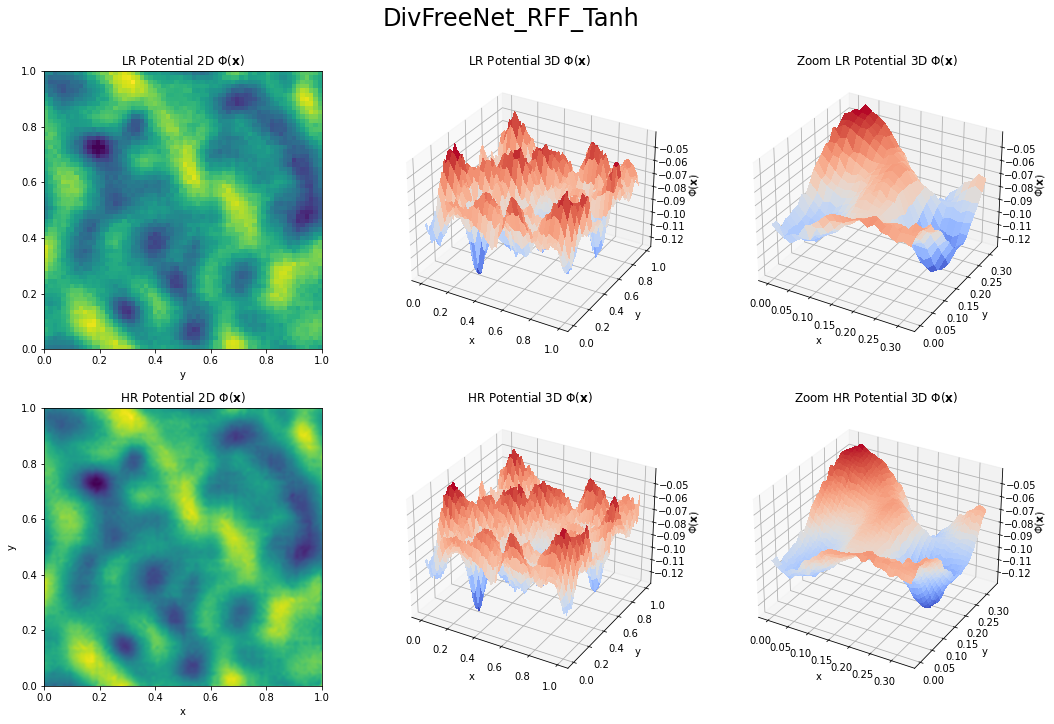

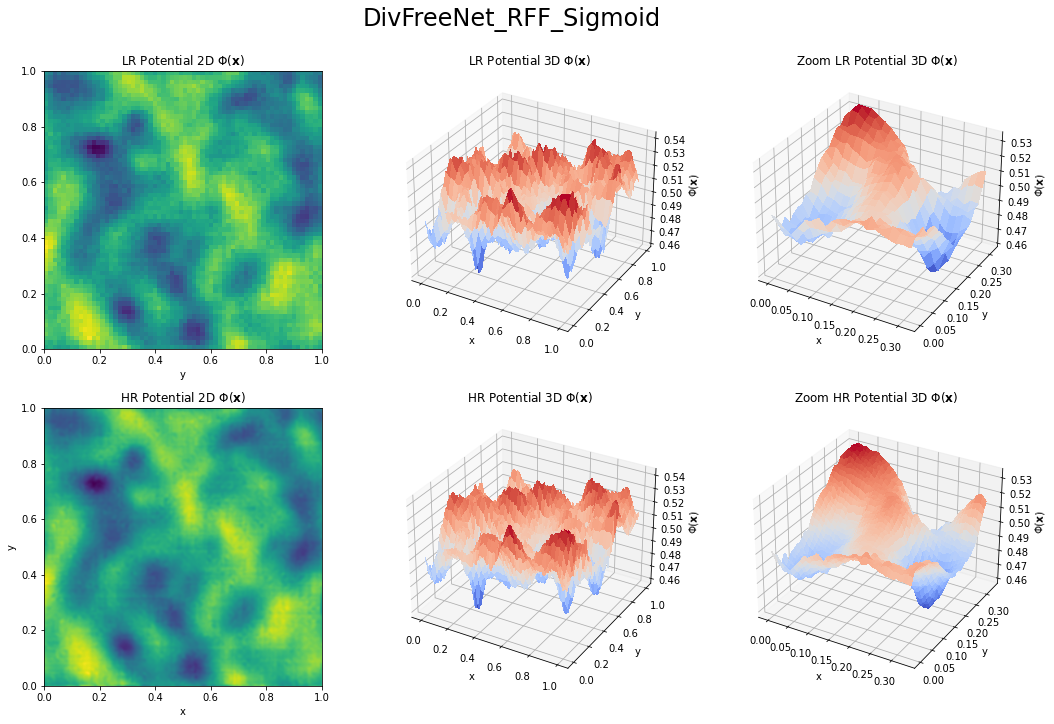

In [77]:
for key in last_activation_funs:
    key = 'DivFreeNet_RFF_%s' % key
    viz.plot_potential_wrapper_res_dict(results_dict[key], title=key)
    plt.show()

### Show errors

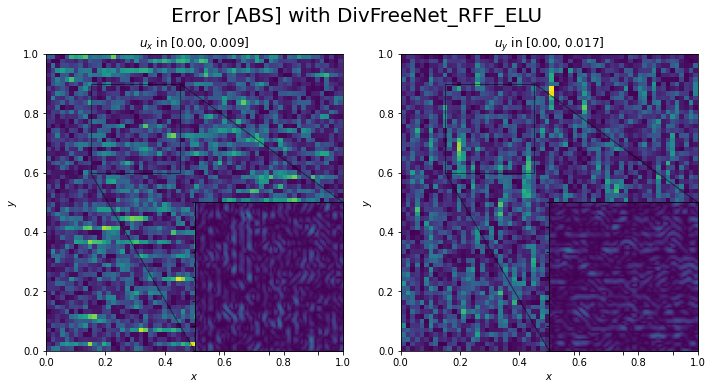

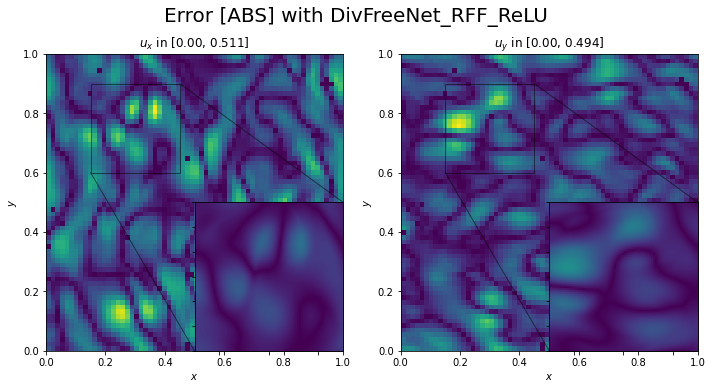

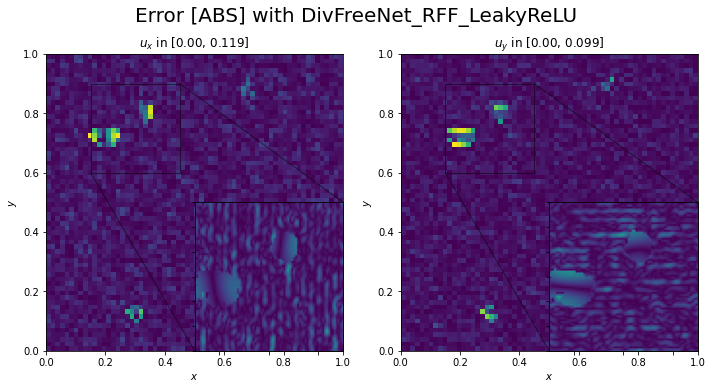

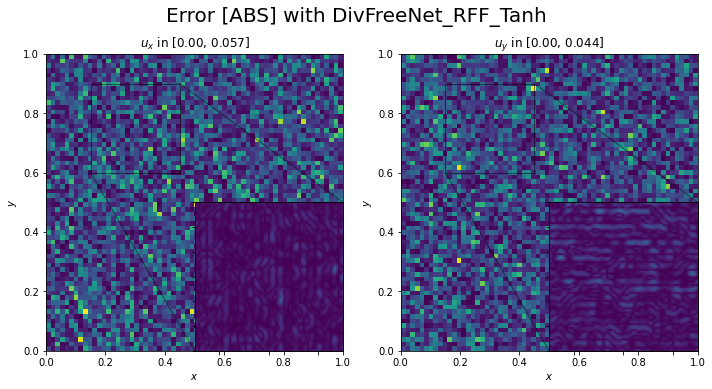

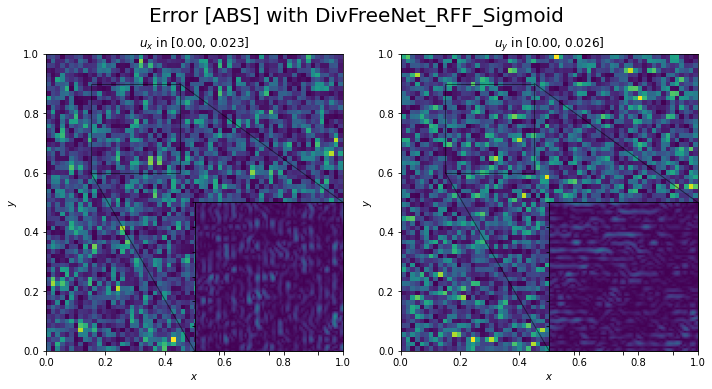

In [79]:
for key in last_activation_funs:
    key = 'DivFreeNet_RFF_%s' % key
    viz.plot_lr_hr_inset_error_wrapper_res_dict(results_dict[key], title='Error [ABS] with %s' % key)
    plt.show()